In [2]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

# 删除重复项

In [6]:
#寻找重复项
client = MongoClient('localhost', 27017)
db = client['中标公示']
collection = db['projects']
pipeline = [
    {"$group": {"_id": {"field1": "$field1", "field2": "$field2"}, "unique_ids": {"$addToSet": "$_id"}, "count": {"$sum": 1}}},
    {"$match": {"count": {"$gt": 1}}}
]
duplicates = collection.aggregate(pipeline)


In [7]:
#删除重复项
for duplicate in duplicates:
    del duplicate['unique_ids'][0]  # 保留一个ID，删除其余的
    for id in duplicate['unique_ids']:
        collection.delete_one({"_id": id})

In [8]:
def read_from_mongodb(host='localhost', port=27017, db_name='中标公示', collection_name='projects', start_date=None, end_date=None):
    """
    Read data from MongoDB and return it as a Pandas DataFrame.

    Parameters:
    host (str): MongoDB host address
    port (int): MongoDB port number
    db_name (str): Name of the database
    collection_name (str): Name of the collection
    start_date (datetime): Start date for filtering
    end_date (datetime): End date for filtering

    Returns:
    df (DataFrame): Data as a Pandas DataFrame
    """
    
    # Initialize MongoDB client and select database and collection
    client = MongoClient(host, port)
    db = client[db_name]
    collection = db[collection_name]
    
    # Define query
    query = {}
    if start_date and end_date:
        query = {
            "中标时间": {
                "$gte": start_date,
                "$lt": end_date
            }
        }
    
    # Execute query and convert the result to a list
    cursor = collection.find(query)
    list_cur = list(cursor)
    
    # Convert the list to a Pandas DataFrame
    df = pd.DataFrame(list_cur)
    
    return df

In [11]:

# Example usage
start_date = datetime(2023, 7, 1)
end_date = datetime(2023, 9, 1)
df = read_from_mongodb(start_date=start_date, end_date=end_date)


In [12]:
len(df)

0

# 数据分析

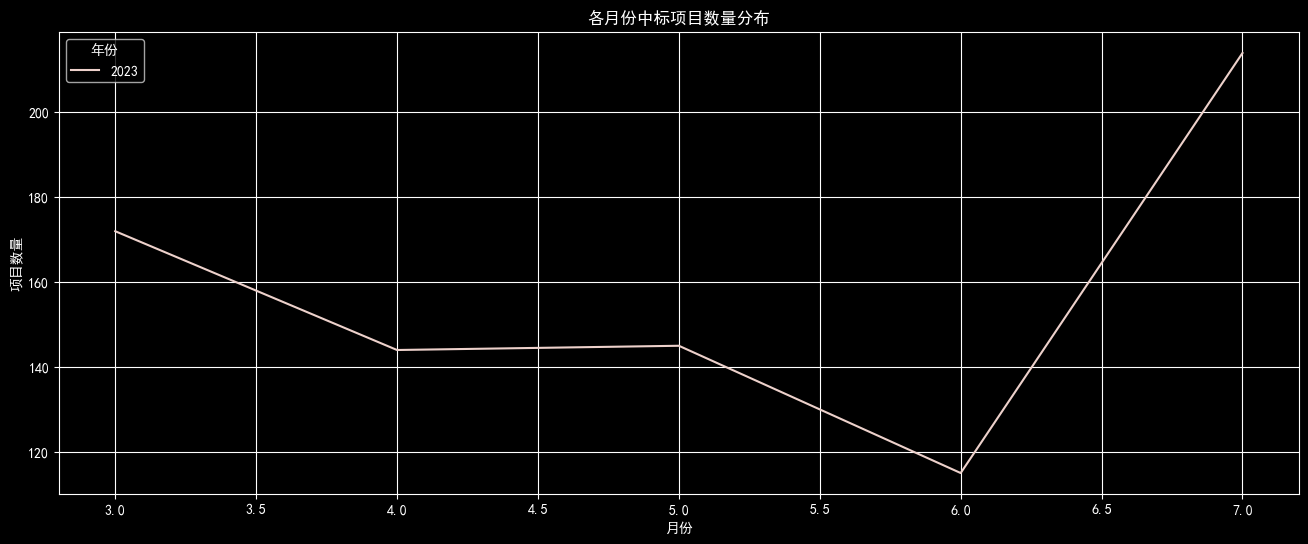

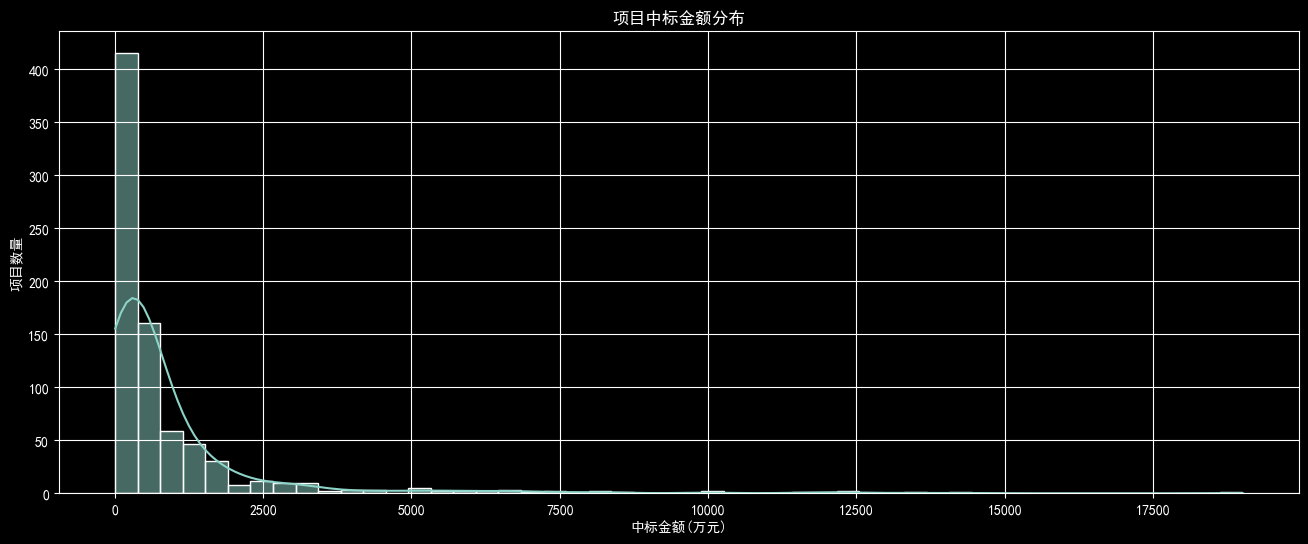

In [65]:
# Extract the month and year from the date
df['中标年份'] = df['中标时间'].dt.year
df['中标月份'] = df['中标时间'].dt.month

# Group by month and count the number of projects and sum the amount
grouped_by_month = df.groupby(['中标年份', '中标月份']).agg({'_id': 'count', '中标金额(万元)': 'sum'}).reset_index()
grouped_by_month.rename(columns={'_id': '项目数量', '中标金额(万元)': '总中标金额(万元)'}, inplace=True)

# Plot by month
plt.figure(figsize=(16, 6))
sns.lineplot(x='中标月份', y='项目数量', hue='中标年份', data=grouped_by_month)
plt.title('各月份中标项目数量分布')
plt.xlabel('月份')
plt.ylabel('项目数量')
plt.legend(title='年份')
plt.grid(True)
plt.show()

# Group by city and count the number of projects and sum the amount
grouped_by_city = df.groupby('城市').agg({'_id': 'count', '中标金额(万元)': 'sum'}).reset_index()
grouped_by_city.rename(columns={'_id': '项目数量', '中标金额(万元)': '总中标金额(万元)'}, inplace=True)

# Group by company and count the number of projects and sum the amount
grouped_by_company = df.groupby('中标公司').agg({'_id': 'count', '中标金额(万元)': 'sum'}).reset_index()
grouped_by_company.rename(columns={'_id': '项目数量', '中标金额(万元)': '总中标金额(万元)'}, inplace=True)

# Plot the distribution of the bid amounts
plt.figure(figsize=(16, 6))
sns.histplot(df['中标金额(万元)'], bins=50, kde=True)
plt.title('项目中标金额分布')
plt.xlabel('中标金额(万元)')
plt.ylabel('项目数量')
plt.grid(True)
plt.show()
